# Topic Modelling
---

In [165]:
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [166]:
# Reproducibility
seed = 42

In [167]:
# Directory containing text files
# text_dir = r"C:\master\aai_data\text-analysis"  # ".\data"
text_dir = "./data/"

## Load all texts

In [168]:
# Read all .txt files from the directory
data_samples = []
for root, dirs, files in os.walk(text_dir):
    if not files:
        continue
    for filename in files:
        if filename.endswith(".txt"):
            with open(os.path.join(root, filename), "r") as file:
                try:
                    data_samples.append(file.read())
                except:
                    print(f"Error reading file: {os.path.join(root, filename)}")

Error reading file: ./data/bbc-train/sports/199.txt


## Feature extraction

In [169]:
# Parameters
n_features = 2000
n_components = 10
n_top_words = 10
batch_size = 128
max_df = 0.95
min_df = 2
init = "nndsvda"

In [170]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stop_words = set(ENGLISH_STOP_WORDS).union({"said", "one", "would", "like", "also"})
custom_stop_words = list(custom_stop_words)

In [171]:
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=n_features, stop_words=custom_stop_words)
tfidf = tfidf_vectorizer.fit_transform(data_samples)

Extracting tf-idf features for NMF...


In [172]:
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, max_features=n_features, stop_words=custom_stop_words)
tf = tf_vectorizer.fit_transform(data_samples)

Extracting tf features for LDA...


## Topic modelling models

In [173]:
# Function to plot top words
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

### NMF

Fitting the NMF model (Frobenius norm)...


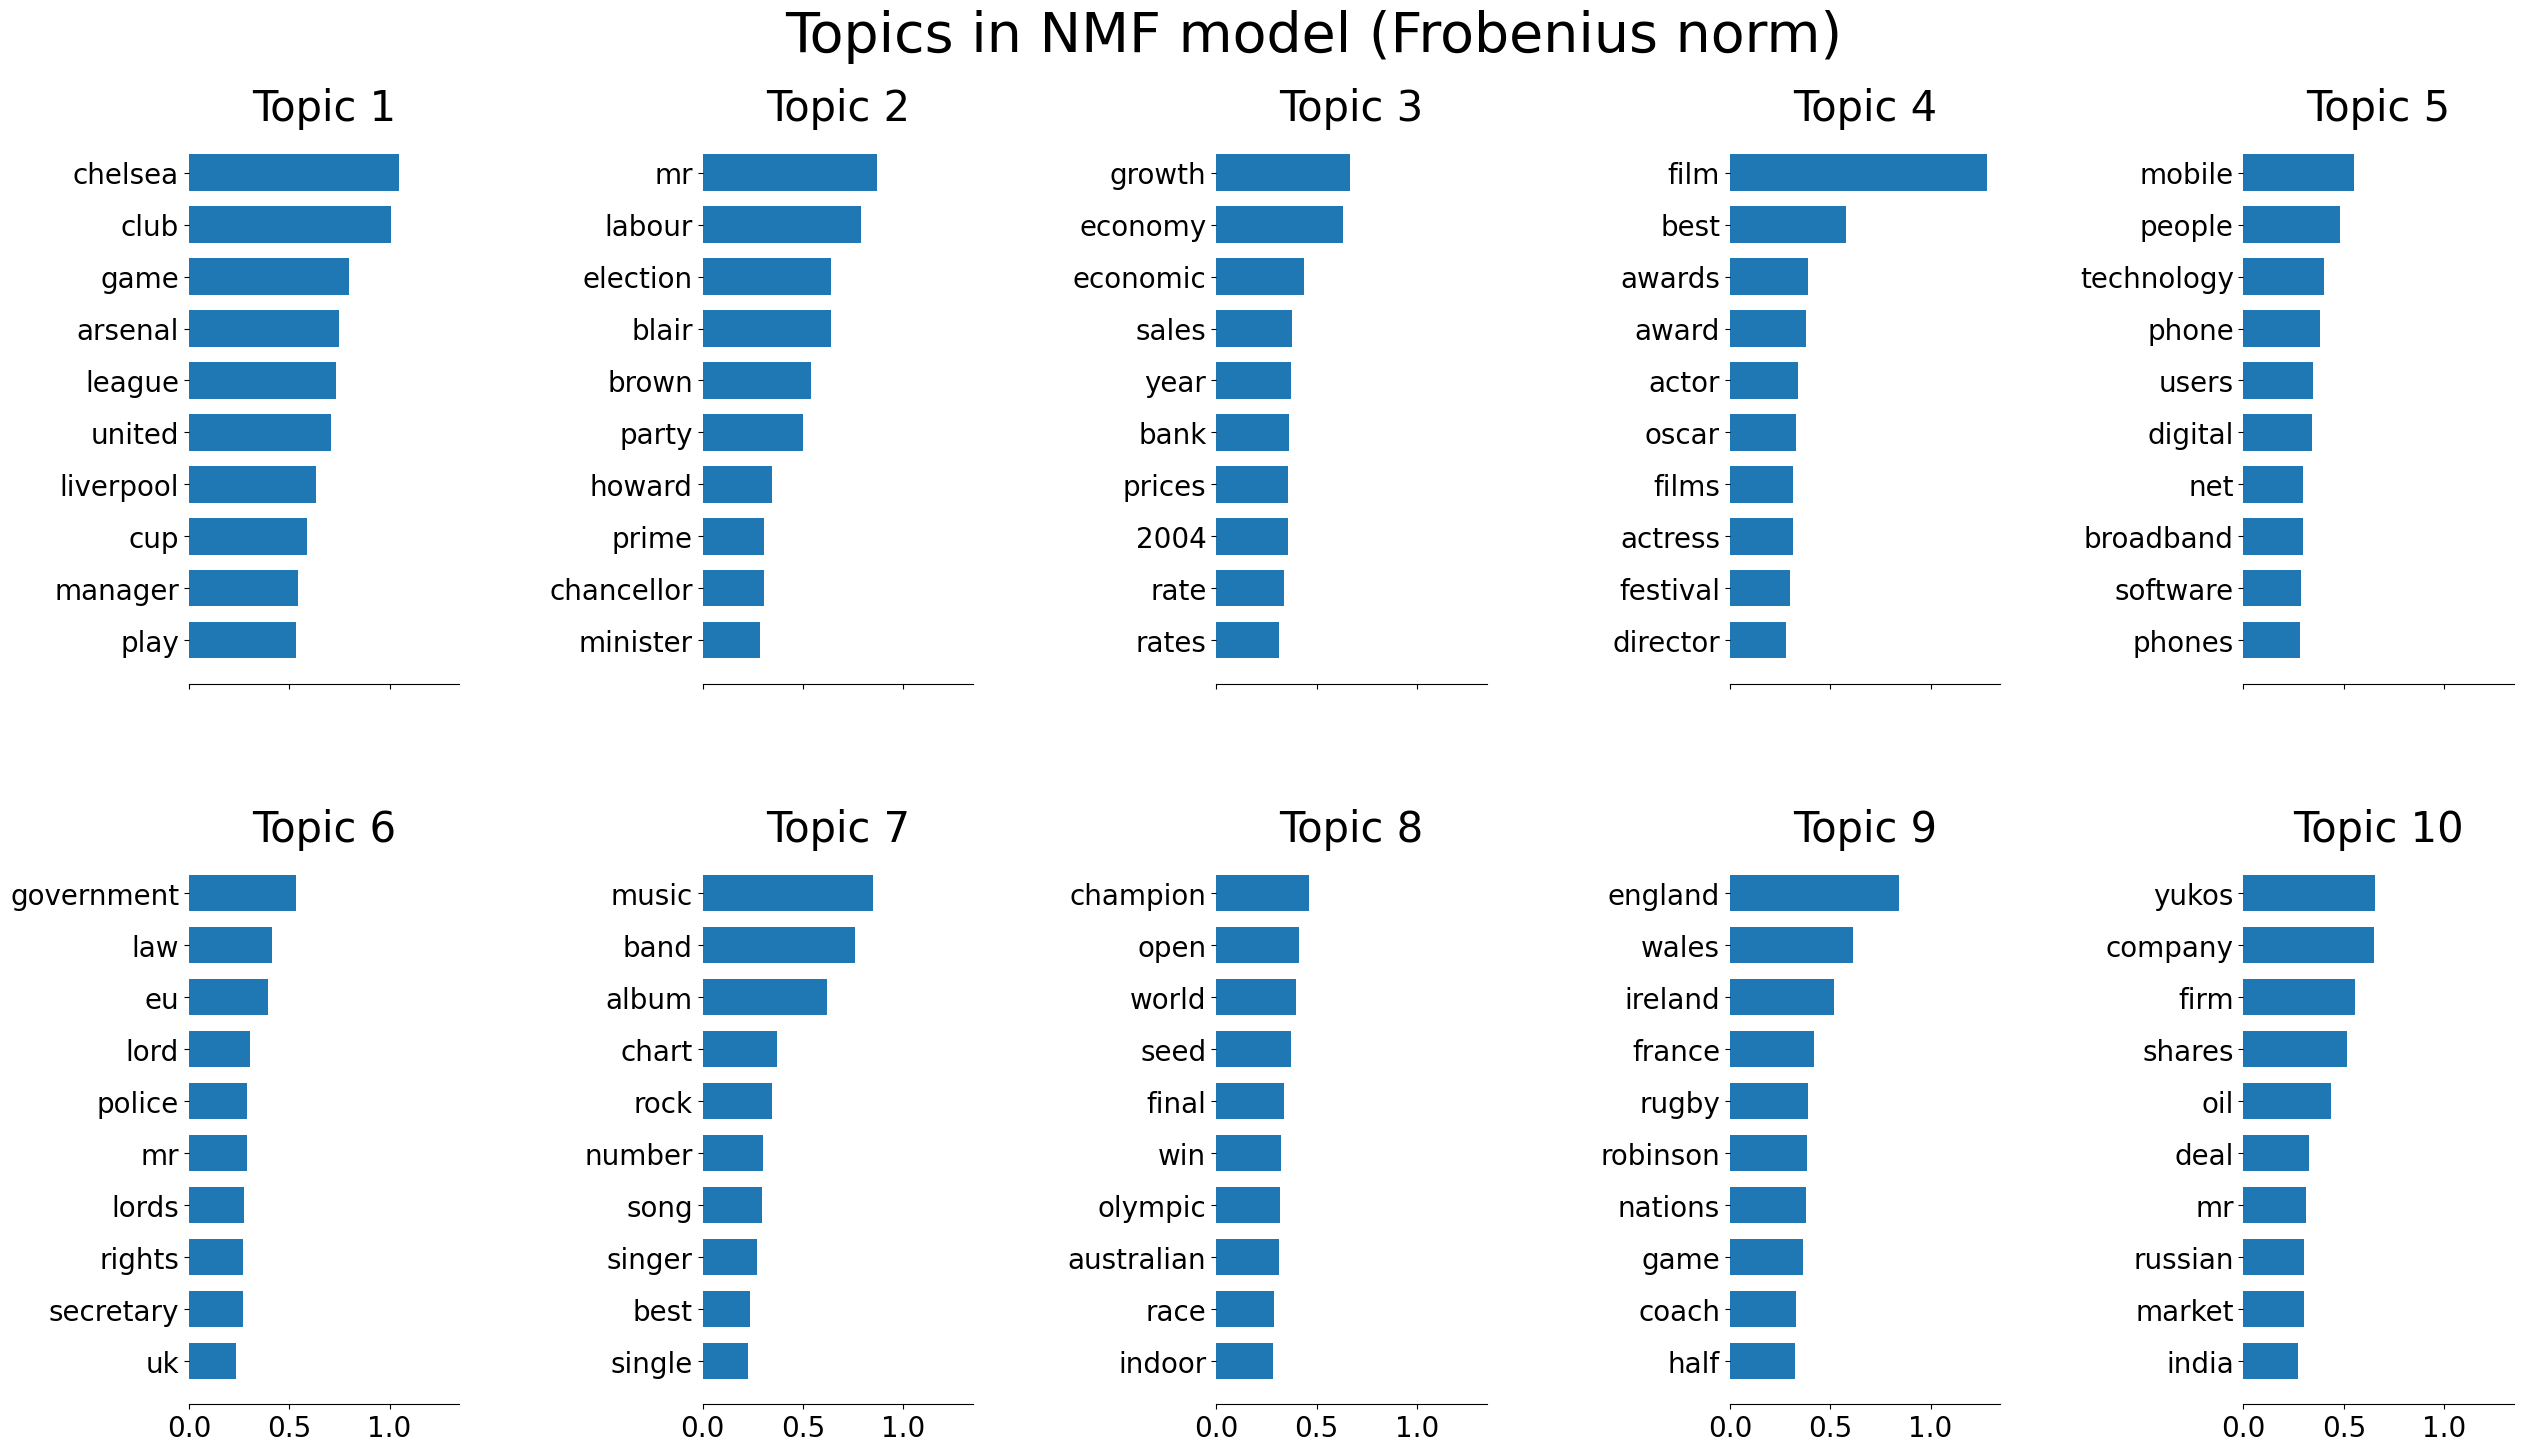

In [174]:
# Fit NMF models
print("Fitting the NMF model (Frobenius norm)...")
nmf = NMF(n_components=n_components, random_state=seed, init=init, beta_loss="frobenius").fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)")

Fitting LDA model...


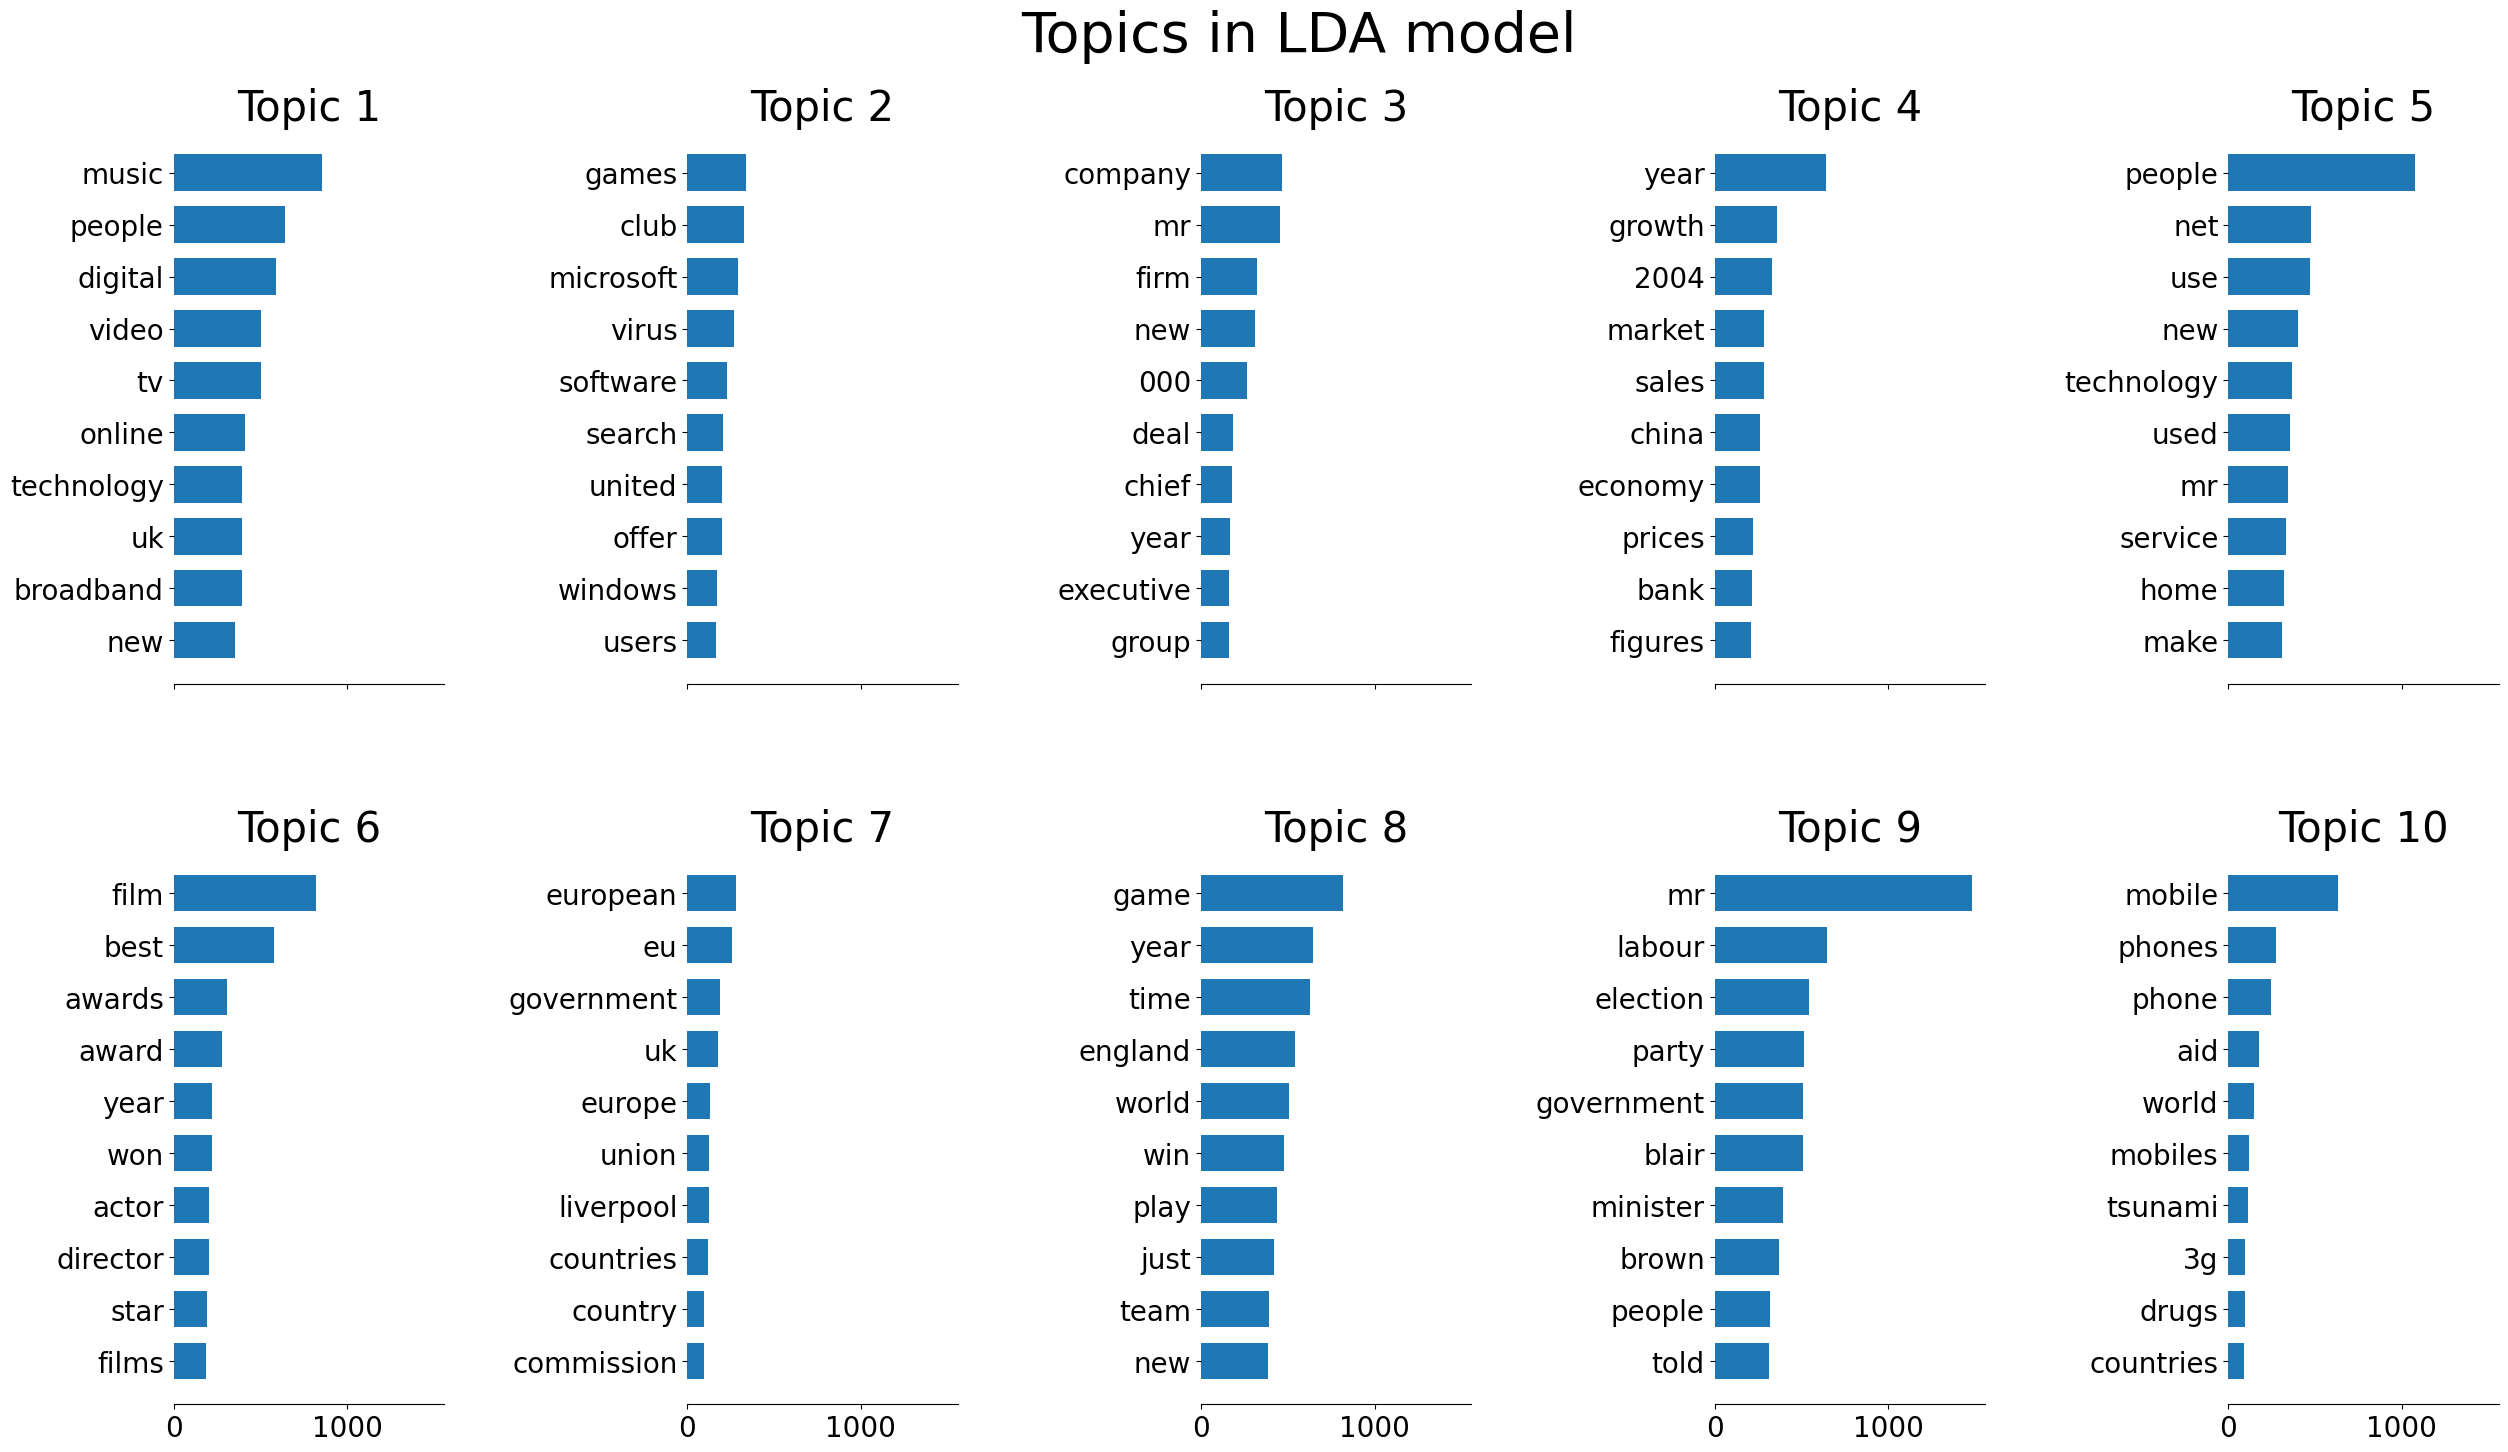

In [175]:
print("Fitting LDA model...")
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5, learning_method="online", random_state=seed)
lda.fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")